In [2]:
import os.path as osp

import torch
from torch_geometric.data import Dataset, Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet(r"C:\Users\ppaul\Documents\AI-strategies-papers-regulations-monitoring\data\s2orc\big_ai_dataset_with_affiliations_extended_oa.parquet")

In [4]:
df.reset_index(inplace=True)

# Pytorch geometric toy network  on papers

In [5]:
id_counts = df['memes_ids'].explode().value_counts()#or meme_ids or noun_chunks_cleaned
ids_appearing_more = id_counts[id_counts > 100].index.tolist()

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=ids_appearing_more)
meme_one_hot = mlb.fit_transform(df['memes_ids'])#noun_chunks_cleaned

c:\Users\ppaul\Documents\influence-on-ideas\ideas_gnn_venv\lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) [0, 1, 10, 100, 1000, 10000, 100001, 100007, 10001, 100010, 100015, 100016, 10002, 100021, 100022, 100024, 100025, 100026, 10003, 100034, 100035, 10004, 100040, 100042, 100048, 10005, 100053, 100055, 100059, 10006, 100066, 10007, 100070, 100071, 100072, 100075, 100077, 100079, 10008, 100081, 100082, 100084, 100085, 100086, 100089, 10009, 100091, 100092, 100094, 1001, 10010, 100100, 100102, 100103, 100105, 100112, 100113, 100119, 10012, 100121, 100125, 100129, 10013, 100130, 100131, 100133, 100134, 100136, 100138, 10014, 100141, 100143, 100145, 100146, 100148, 10015, 100150, 100151, 100156, 100157, 100159, 10016, 100167, 100168, 10017, 100172, 100173, 100174, 100175, 100177, 100179, 10018, 100181, 100184, 100186, 100189, 10019, 100196, 100201, 100203, 100205, 100209, 10021, 100213, 100216, 10022, 100223, 100226, 10023, 100232, 100234, 100236, 1

In [7]:
#dict from the position to name in the position
meme_dict = {i: meme for i, meme in enumerate(list(mlb.classes_))}


In [8]:
df_edge = df.explode(column='outbound_citations')[['paper_id','outbound_citations']].dropna()
df_edge['outbound_citations'] = df_edge['outbound_citations'].apply(int)
edges = df_edge.merge(df['paper_id'],left_on='outbound_citations',right_on='paper_id',how='inner').drop(columns=['paper_id_y']).rename(columns={'paper_id_x':'paper_id'})
paper_ids_dict = {paper_id: index for index, paper_id in enumerate(df['paper_id'])}
edges['paper_id'] = edges['paper_id'].apply(lambda x: paper_ids_dict[x])
edges['outbound_citations'] = edges['outbound_citations'].apply(lambda x: paper_ids_dict[x])

In [9]:
from sklearn.preprocessing import normalize


In [10]:

node_features = torch.tensor(np.concatenate((normalize(df[['BT_percent','authors_number', 'double_affiliation']].values, axis=1, norm='max'),meme_one_hot),axis=1))

edge_array = edges.values.T

# Create the edge_index tensor as a PyTorch LongTensor
edge_index = torch.tensor(edge_array, dtype=torch.long)

data = Data(x=node_features,
            edge_index=edge_index,
            y=df.BT_percent 
            )

In [12]:
data.validate(raise_on_error=True)

True

In [13]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
import torch_geometric.transforms as T
transform = T.RandomLinkSplit(
    num_val=0.01,
    num_test=0.1,
    #disjoint_train_ratio=0.3,
    #neg_sampling_ratio=2.0,
    add_negative_train_samples=False
)

train_data, val_data, test_data = transform(data)
train_data, val_data, test_data = train_data.to(device), val_data.to(device), test_data.to(device)

In [15]:
from torch_geometric.loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data.edge_label_index
edge_label = train_data.edge_label


train_loader = LinkNeighborLoader(
    train_data,
    num_neighbors=[30] * 2,
    batch_size=256,
    edge_label_index=edge_label_index,
    edge_label=edge_label,
)
test_loader = LinkNeighborLoader(
    test_data,
    num_neighbors=[30] * 2,
    batch_size=256,
    edge_label_index=test_data.edge_label_index,
    edge_label=test_data.edge_label,
)

In [15]:
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from torch import Tensor


class Model(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(in_channels, hidden_channels)
        
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        # cosine similarity
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim = -1)

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list 

  
model = Model(in_channels= np.shape(train_data.x)[1], hidden_channels=64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.005)


In [ ]:
model.load_state_dict(torch.load('model_weights20Nov.pth'))
model.eval()

RuntimeError: Error(s) in loading state_dict for Model:
	size mismatch for conv1.lin_l.weight: copying a param with shape torch.Size([64, 2689]) from checkpoint, the shape in current model is torch.Size([64, 5103]).
	size mismatch for conv1.lin_r.weight: copying a param with shape torch.Size([64, 2689]) from checkpoint, the shape in current model is torch.Size([64, 5103]).

In [16]:
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
from torch_geometric.utils import negative_sampling

def train(train_loader):
    """
    Single epoch model training in batches.
    :return: total loss for the epoch
    """
    model.train()
    total_examples = total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        batch = batch.to(device)
        batch_size = batch.size()[0]
        z = model.forward(batch.x.float(), batch.edge_index)
        neg_edge_index = negative_sampling(edge_index = batch.edge_index, num_nodes = batch.num_nodes, num_neg_samples = None, method = 'sparse')
        edge_label_index = torch.cat([batch.edge_label_index, neg_edge_index], dim = -1, )
        edge_label = torch.cat([torch.ones(batch.edge_label_index.size(1)), torch.zeros(neg_edge_index.size(1))], dim = 0)#.to(device)
        
        out = model.decode(z, edge_label_index).view(-1)
        #loss = F.binary_cross_entropy_with_logits(out[:batch_size], edge_label[:batch_size])
        loss = F.binary_cross_entropy_with_logits(out, edge_label)
        # standard torch mechanics here
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * batch_size
        total_examples += batch_size
    return total_loss, total_examples



@torch.no_grad()
def test(loader):
    """
    Evalutes the model on the test set.
    :param loader: the batch loader
    :return: a score
    """
    model.eval()
    f1scores = []
    accuracies = []
    threshold = torch.tensor([0.7]).to(device)
    for batch in tqdm(loader):
        batch.to(device)
        z = model.forward(batch.x.float(), batch.edge_index)
        out = model.decode(z, batch.edge_label_index).view(-1).sigmoid()
        pred = (out > threshold).float() * 1
        pred = pred.detach().cpu().numpy()
        f1score = f1_score(batch.edge_label, pred)
        f1scores.append(f1score)
        accuracy = accuracy_score(batch.edge_label, pred)
        accuracies.append(accuracy)
    return np.average(f1scores), np.average(accuracies)




In [17]:

for epoch in range(1, 7):
    loss, total_examples = train(train_loader)
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Examples: {total_examples}")

f1, accuracy = test(test_loader)
print(f"f1: {f1:.5f}, accuracy: {accuracy:.5f}")

100%|██████████| 792/792 [03:00<00:00,  4.39it/s]


Epoch: 001, Loss: 4180575.9751, Examples: 6043113


100%|██████████| 792/792 [03:10<00:00,  4.15it/s]


Epoch: 002, Loss: 4173683.4481, Examples: 6048656


100%|██████████| 792/792 [03:13<00:00,  4.08it/s]


Epoch: 003, Loss: 4172776.6122, Examples: 6052311


100%|██████████| 792/792 [03:29<00:00,  3.78it/s]


Epoch: 004, Loss: 4169618.7830, Examples: 6050218


100%|██████████| 792/792 [03:24<00:00,  3.88it/s]


Epoch: 005, Loss: 4163173.9549, Examples: 6042917


100%|██████████| 792/792 [03:21<00:00,  3.92it/s]


Epoch: 006, Loss: 4162042.5339, Examples: 6043676


100%|██████████| 178/178 [00:17<00:00,  9.90it/s]

f1: 0.19533, accuracy: 0.60978


# XGBoost

In [11]:
#positive edges
pos_edges = edges.apply(lambda x: np.concatenate((node_features[x['paper_id'],:], node_features[x['outbound_citations'],:])),axis=1)



In [43]:
torch.tensor(pos_edges)

RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 5239456560 bytes.

In [14]:
edges.reset_index(inplace=True)
edge_series = edges.set_index('paper_id')

In [15]:
edges.drop(columns=['index'],inplace=True)

In [16]:
edge_dict = edge_series.to_dict()['outbound_citations']

In [18]:
#negative edges are randomly sampled - but prob of finding a positive edge is very low
def sample_neg_edges():
    random_in_node = np.random.randint(0,node_features.shape[0])
    random_out_node = np.random.randint(0,node_features.shape[0])
    if random_out_node!=random_in_node and (random_out_node not in edge_dict.keys() or edge_dict[random_out_node]!=random_in_node):
        return torch.tensor(np.concatenate((node_features[random_in_node,:], node_features[random_out_node,:]))).unsqueeze(1)
    else:
        return sample_neg_edges()

In [19]:
neg_edges = sample_neg_edges()
for i in range(len(pos_edges)):
    neg_edges = torch.cat((neg_edges, sample_neg_edges()), 1)

KeyboardInterrupt: 

In [21]:
neg_edges.shape

torch.Size([2878, 9905])

In [ ]:
def check_edge(node1,node2):
    if node2 in edges[edges['paper_id']==node1]['outbound_citations'].values:
        return 1
    else:
        return 0

In [21]:
edges
#sample two nodes from edges - that's input. Label is 1 if there is an edge between them. Sample negative edges and label them with 0.

#edges.map(lambda x: np.concatenate((x['paper_id'], x['outbound_citations'])), axis=1)
for i in range(edges.shape[0]):
    for j in range(edges.shape[0]):
        if i != j:
            np.concatenate((node_features[edges.iloc[i]['paper_id']], node_features[edges.iloc[j]['outbound_citations']]))

KeyboardInterrupt: 

In [ ]:
import xgboost as xgb
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
xgb.train(param, train_data)

# plan
pdp on 

* Ustawiać seeda
* dict memów - Staś ma wydobyć
* dodać odczytywanie meme dict
* doprowadzić do trenowania (jakiegokolwiek - jednak mniejszy lr)
* ALE
* przerzucić wszystko do projektu

Problem z PDP: conditional (M-plot) vs marginal(PDP): I include unlikely data instances that I get by simply modyifying the feature
Na ile to rozumiem sztucznie przestawiam wszystkie wartości lub używam tylko tych wartości, któe naturalnie są blisko (tą drugą wersję zaimplementować)

Czy dla kategorialnych binarnych zmiennych wynik(z memem) - wynik(bez mema) to już ALE? sprawdzić zamiast ilorazu.

Jak na chłopski rozum działa ALE 2D? -> w paperze formułki 13-16. Obczaić czy czyjaś interpretacja, czy własna interpretacja nie będzie prosta
dale- unbiased ALE?



## ALE: interpretation
First order: for regressive feature: BT%. For the papers having this feature in certain range, we set their feature's values to the top and bottom ends of the range and subtract. Divide the difference by the number of samples in the range. Then we 'accumulate' this effect over ranges up to the value that interests us by summing it up. We subtract the mean of ale for all the samples to make it unbiased (accordig to some unsuccesfully?) 

First order: for binary categorical - just look at the difference between setting it to both values. Divide by the number of samples. Subtract the mean of ale of all samples. Similar to what already is here. Where is the accumulation?

Second order. For each sample in the range we get the difference of for the first feature for two consecutive values of the second feature and then we difference them. We get the mean for the range and then sum over all ranges up to the range in which is the interesting value. This is the unbiased version. We subtract the differences of ale for all samples for both features. And then we subtract the two-feature ale for all features.

In [ ]:
import random
def graph_pdp_cat(dataset, model, column, values):
    '''function to plot the partial dependence plot
    data: ??
    model: the pyg model for link prediction
    column: the column index
    values: list of values to check the partial dependence for
    Example: How much probable is on average to cite a paper if it is coauthored solely by Big tech authors than having a mixed affiliation?
    '''
    #TODO: change the values separately and compute the probability of citation for only the changed values!
    #TODO: check if the first is cited or citing?
    probabilities = {}
    random_papers = random.choices(range(dataset.__len__()), k=100)
    
    for paper in random_papers:
        
        for value in values:
            
            dataset.x[paper, column] = torch.tensor(value)
            unique = dataset.edge_index.unique().unsqueeze(1)[:256,:]
            #paper should not be in the unique!!!
            edge_label_index = torch.cat((unique, int(paper)*torch.ones(unique.shape)),dim=1).type(torch.LongTensor).to(device)
            dataset = dataset.to(device)

            val_loader = LinkNeighborLoader(
                        dataset,
                        num_neighbors=[30] * 2,
                        batch_size=256,
                        edge_label_index=edge_label_index,
                        edge_label=dataset.edge_label,
                    )
            
            probabilities[value] = []

            for batch in val_loader:
                z = model.forward(batch.x.float(), batch.edge_index)
                out = model.decode(z, batch.edge_label_index).view(-1).sigmoid()
                
                probabilities[value] = np.concatenate((probabilities[value],out.detach().cpu().numpy()),axis=0)
            probabilities[value] = probabilities[value].mean()
    print(probabilities)
    plt.plot(values, probabilities.values())
    plt.xlabel(column)
    plt.ylabel('Mean probability of being cited')

{0.0: 0.5013514757156372, 0.1: 0.5017927885055542, 0.2: 0.5023556649684906, 0.3: 0.5026779472827911, 0.4: 0.5026889443397522, 0.5: 0.5026999413967133, 0.6: 0.5027109682559967, 0.7: 0.5027220547199249, 0.8: 0.5027331709861755, 0.9: 0.5029683709144592, 1.0: 0.5032820403575897}


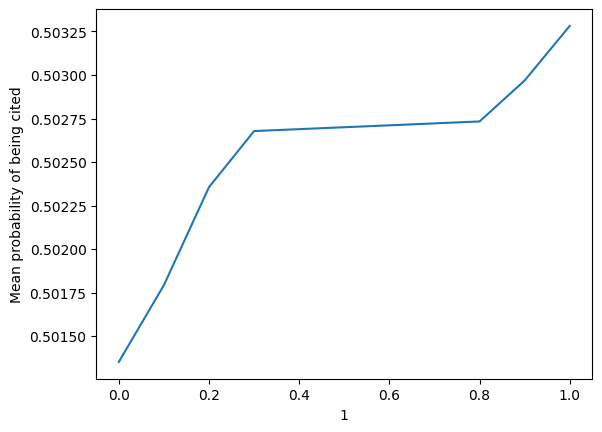

In [ ]:
graph_pdp_cat(val_data, model, 1, [i/100 for i in range(0,110,10)])

In [ ]:
import random
import seaborn as sns
def graph_pdp_meme(dataset, model, column_after):
    '''function to rank the memes according  partial dependence plot for them
    data: ??
    model: the pyg model for link prediction
    column_after: the column index, after which all columns are one -hot encoding of memes
    Example: How much probable is on average to cite a paper if it has a meme than when it doesn't?
    '''

    random_papers = random.choices(range(dataset.__len__()), k=3)
    memes_coeff = []
    for meme in tqdm(range(column_after,dataset.x.shape[1])):
        list_of_probabilities = []
        for paper in random_papers:
        
            #for no meme
            dataset.x[paper, meme] = torch.tensor(0)
            unique = dataset.edge_index.unique().unsqueeze(1)[:256,:]
            #paper should not be in the unique!!!
            edge_label_index = torch.cat((unique, int(paper)*torch.ones(unique.shape)),dim=1).type(torch.LongTensor).to(device)
            dataset = dataset.to(device)

            val_loader = LinkNeighborLoader(
                        dataset,
                        num_neighbors=[30] * 2,
                        batch_size=256,
                        edge_label_index=edge_label_index,
                        edge_label=dataset.edge_label,
                    )
            
            prob_no_meme = np.array([])
            for batch in val_loader:
                z = model.forward(batch.x.float(), batch.edge_index)
                out = model.decode(z, batch.edge_label_index).view(-1).sigmoid()
                
                prob_no_meme = np.concatenate((prob_no_meme,out.detach().cpu().numpy()),axis=0)
            prob_no_meme = prob_no_meme.mean()
            #for meme
            dataset.x[paper, meme] = torch.tensor(1)
            unique = dataset.edge_index.unique().unsqueeze(1)[:256,:]
            #paper should not be in the unique!!!
            #is changing the value during iterating through batches more efficient?
            edge_label_index = torch.cat((unique, int(paper)*torch.ones(unique.shape)),dim=1).type(torch.LongTensor).to(device)
            dataset = dataset.to(device)

            val_loader = LinkNeighborLoader(
                        dataset,
                        num_neighbors=[30] * 2,
                        batch_size=256,
                        edge_label_index=edge_label_index,
                        edge_label=dataset.edge_label,
                    )
            
            prob_meme = np.array([])
            for batch in val_loader:
                z = model.forward(batch.x.float(), batch.edge_index)
                out = model.decode(z, batch.edge_label_index).view(-1).sigmoid()
                
                prob_meme = np.concatenate((prob_meme,out.detach().cpu().numpy()),axis=0)
            prob_meme = prob_meme.mean()
            list_of_probabilities.append(prob_no_meme/prob_meme)
        memes_coeff.append(np.mean(list_of_probabilities))
    return  memes_coeff


In [ ]:
dict_of_memes = dict(zip(mlb.classes_[1:], meme_scores))

In [ ]:
pd.DataFrame({'meme':mlb.classes_[1:], 'score':meme_scores}).sort_values(by='score',ascending=False).to_csv('meme_scores.csv')

In [ ]:
mlb.classes_

array(['paper', 'result', 'method', ..., 'well generalization', 'bcis',
       'rule set'], dtype=object)

In [ ]:
meme_scores = graph_pdp_meme(val_data, model, 5)

100%|██████████| 5098/5098 [51:21<00:00,  1.65it/s]  


In [ ]:
[i/10 for i in range(0,100,10)]

TypeError: can't multiply sequence by non-int of type 'float'

{0.0: 0.6031138002872467}


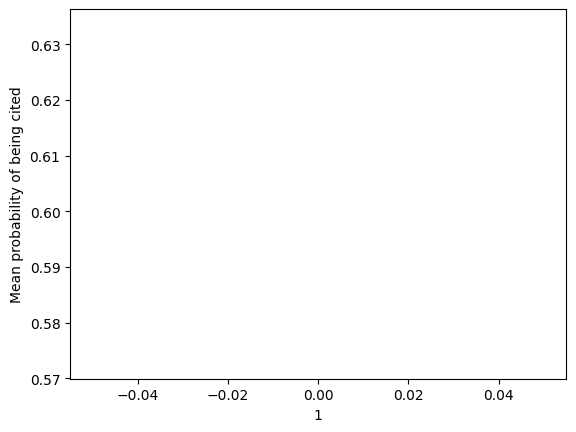

In [ ]:
graph_pdp_cat(val_data, model, 1, [i/10 for i in range(0,100,10)])

In [ ]:
import dalex as dx

def predict_function(data):
    threshold = torch.tensor([0.7]).to(device)
    z = model.forward(data.x.float(), data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    pred = (out > threshold).float() * 1
    return pred.detach().cpu().numpy()


explainer = dx.Explainer(model, test_data, test_data.edge_label, predict_function = predict_function)
#pdp = explainer.model_profile()



Preparation of a new explainer is initiated



TypeError: 'data' must be pandas.DataFrame or numpy.ndarray

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(clf, X, features)

Partial dependence plot (planowo: jednoczynnikowe: obecność memu/%bigtechowości) - muszę chyba napisać samodzielnie? dalex - na numpy.ndarray, sklearn tym bardziej?

ALE (planowo: to co wyżej: interakcje między memem, a bigtechowością - zrozumieć czy symetrycznie się liczy?) - pyALE? ale chyba te same problemy techniczne 

In [ ]:
import dalex as dx


class PDP():
    def __init__(self, model, dataset:pd.Dataframe, affilation_column:str, device):
        self.model = model
        self.dataset = dataset
        self.affilation_column = dataset[affilation_column]
        self.device = device

    def get_affiliation_importance(self):
           
        """
        Get affiliation importance using PDP.
        I(%affiliation) = Sum_u,v(Prob(uv in E(G)|u has %affiliation))
        """
        def predict_function(x):
            return self.model.decode_all(x).float()#CHECK
        explainer = dx.Explainer(self.model, self.dataset.x, self.dataset.y, predict_function = predict_function)
        pdp = explainer.model_profile()
        pdp.plot(variables = self.affilation_column)


    def get_meme_importance(self,loader):
        """
        Get meme importance using PDP.
        I(meme) = Sum_u,v(Prob(uv in E(G)|u has the meme))/Prob(uv in E(G)|u does not have the meme)
        """
        meme_importance = pd.Series()
        for meme in self.dataset.columns:
            data_pos = self.dataset.copy()
            data_pos[meme].values.fill(1)
            data_neg = self.dataset.copy()
            data_neg[meme].values.fill(0)
            #loader
            out_pos = []
            out_neg = []
            for batch in tqdm(loader):
                batch.to(self.device)
                z = self.model.forward(batch.x.float(), batch.edge_index)
                out = self.model.decode(z, batch.edge_index).view(-1).sigmoid()
                out_pos.append(out)#concatenate instead of append

            meme_importance[meme] = torch.mean(out_pos)/torch.mean(out_neg)

        return meme_importance
    
    



ModuleNotFoundError: No module named 'dalex'

In [ ]:
class OpenAlexDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2', ...]

    @property
    def processed_file_names(self):
        return ['data_1.pt', 'data_2.pt', ...]

    def download(self):
        df = pd.read_csv(path)
        

    def process(self):
        idx = 0
        for raw_path in self.raw_paths:
            # Read data from `raw_path`.
            data = Data(...)

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1

        out_path = (self.processed_dir, "some_unique_filename.pt")
        # read your point cloud here, 
        # convert point cloud to Data object
       
        data = Data(x=node_features,
                    edge_index=edge_index,
                    #edge_attr=edge_attr,
                    #y=label #you can add more arguments as you like
                    )
        torch.save(data, out_path)
        return

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data
    
    def get_node_features(self):
        pass

    def get_edge_features(self):
        pass

In [ ]:

# Load your dataset and retrieve the list of paper IDs
# Note: This assumes that the paper IDs are stored in a variable named `paper_ids`
dataset = df  # Load your dataset here
paper_ids = df.index  # Retrieve the list of paper IDs

# Create a mapping between original node IDs and reindexed node IDs
node_dict = {paper_id: i for i, paper_id in enumerate(paper_ids)}

# Update the node indices in the edge_index tensor
edge_index = dataset.data.edge_index
edge_index_reindexed = torch.tensor([[node_dict[u], node_dict[v]] for u, v in edge_index], dtype=torch.long).T
dataset.data.edge_index = edge_index_reindexed

# Update the node indices in the x feature matrix
x = dataset.data.x
x_reindexed = x[:, node_dict.keys()]
dataset.data.x = x_reindexed

# Update any other parts of the dataset that depend on node indices, if necessary
